In [6]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import os

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import renyi
import utils
import sxp

from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
os.makedirs('./data/mnist', exist_ok=True)

mnist = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/mnist', train=True, download=True,))
letters = torch.utils.data.DataLoader(torchvision.datasets.EMNIST('./data/emnist', 'letters', train=True, download=True,))
fashion = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST('./data/fashion', train=True, download=True))

In [8]:
img_size = 28#50

[Ygrid, Xgrid] = np.meshgrid(np.linspace(0, 1, img_size), np.linspace(0, 1, img_size))
Kmat = np.exp(-np.abs(Xgrid - Ygrid)**1/(0.04**2))
Kmat = torch.tensor(Kmat)

img_kernel = lambda x: torch.matmul(torch.matmul(Kmat, x), Kmat)

tform = torchvision.transforms.Compose(
                      [torchvision.transforms.ToPILImage(),
                       torchvision.transforms.RandomAffine(10, translate=(0., 0.), scale=(0.5, 1), shear=0, resample=False, fillcolor=0),
                       torchvision.transforms.ToTensor()
                      ])

### Show data samples

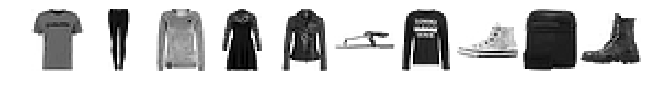

In [12]:
toshow = []
for digit in range(0, 10):
    ix = data.dataset.train_labels == digit
    D = data.dataset.train_data[ix].view(-1, 28, 28).float()
    toshow.append(D[np.random.choice(D.shape[0])])
    
plt.figure(figsize=(11, 2))
#toshow = D[np.random.choice(D.shape[0])] / D[np.random.choice(D.shape[0])].sum() 
plt.imshow(torch.cat(toshow, dim=1).data.numpy(), cmap='gray_r')
plt.axis('off')
plt.show()

### Compute barycenters

In [16]:
alpha = 1.5

barys = []

data = fashion

for digit in range(0, 10):
    start = time()
    ix = data.dataset.train_labels == digit

    D = data.dataset.train_data[ix].view(-1, 28, 28).float()
    
    # for EMNIST
    #D = data.dataset.train_data[ix].view(-1, 28, 28).transpose(-1, -2).float()
    
    logit_mu = torch.nn.Parameter(0*torch.rand(1, img_size*img_size))
    temp = torch.nn.Parameter(torch.tensor(1.))

    optimizer = torch.optim.Adam([logit_mu, temp], lr=0.05, amsgrad=True)
    
    for i in range(250):

        optimizer.zero_grad()
        
        mu = torch.softmax(logit_mu /  torch.exp(temp), dim=1).view(1, img_size, img_size) 
        nu = utils.sample_and_resize(D[0:-1, ...], img_size, 32)
        
        #loss = renyi.renyi_sim_divergence(img_kernel, nu, mu, alpha, False).mean()
        loss = renyi.mink_sim_divergence(img_kernel, nu, mu, alpha, False).mean()
        
        if i % 100 == 0:
            print("%d - %d - %.3e" % (digit, i, loss.item()))

        if False and i % 100 == 0:
            mu = torch.softmax(logit_mu /  torch.exp(temp), dim=1).view(img_size, img_size).data
            plt.figure(figsize=(1, 1))
            plt.imshow(mu, cmap='gray_r');
            plt.show()

        loss.backward()
        optimizer.step()
    
    mu = torch.softmax(logit_mu /  torch.exp(temp), dim=1).view(img_size, img_size)
    barys.append(mu.data)
    
    print('Class time: ', time()-start)

0 - 0 - 1.683e-03
0 - 100 - 1.145e-03
0 - 200 - 9.777e-04
Class time:  2.136859655380249
1 - 0 - 3.023e-03
1 - 100 - 1.269e-03
1 - 200 - 1.240e-03
Class time:  2.2817749977111816
2 - 0 - 1.254e-03
2 - 100 - 6.152e-04
2 - 200 - 8.986e-04
Class time:  1.9489612579345703
3 - 0 - 2.705e-03
3 - 100 - 1.243e-03
3 - 200 - 1.226e-03
Class time:  2.223681688308716
4 - 0 - 1.445e-03
4 - 100 - 8.136e-04
4 - 200 - 7.463e-04
Class time:  2.2627859115600586
5 - 0 - 5.047e-03
5 - 100 - 4.021e-03
5 - 200 - 3.516e-03
Class time:  2.3867316246032715
6 - 0 - 1.398e-03
6 - 100 - 1.142e-03
6 - 200 - 1.048e-03
Class time:  1.9787790775299072
7 - 0 - 4.094e-03
7 - 100 - 1.954e-03
7 - 200 - 2.033e-03
Class time:  2.303175926208496
8 - 0 - 1.562e-03
8 - 100 - 1.181e-03
8 - 200 - 1.105e-03
Class time:  2.2904789447784424
9 - 0 - 1.864e-03
9 - 100 - 9.605e-04
9 - 200 - 9.155e-04
Class time:  2.18135666847229


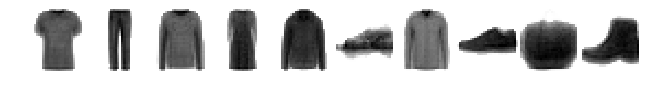

In [17]:
plt.figure(figsize=(1.1*len(barys), 2.5))
cat_barys = torch.cat( [ (_ - _.min()) / (_.max() - _.min())   for _ in barys], dim=1)
plt.imshow(cat_barys, cmap='gray_r')
plt.axis('off')
plt.show()

### Image interpolation 

In [20]:
p, q = D[17].view(1, 28, 28).double() , D[281].view(1, 28, 28).double()
p, q = p/p.sum(), q/q.sum()


alpha = 2
thetas = [0.2, .5, 0.7] 

0.200 - 0 - 2.1435e-03
0.200 - 200 - 4.1705e-04
0.200 - 400 - 3.8828e-04
0.200 - 600 - 3.8002e-04
0.200 - 800 - 3.7608e-04
0.500 - 0 - 2.0007e-03
0.500 - 200 - 9.2511e-04
0.500 - 400 - 9.1640e-04
0.500 - 600 - 9.1383e-04
0.500 - 800 - 9.1262e-04
0.700 - 0 - 1.9054e-03
0.700 - 200 - 5.9128e-04
0.700 - 400 - 5.6788e-04
0.700 - 600 - 5.6208e-04
0.700 - 800 - 5.5947e-04


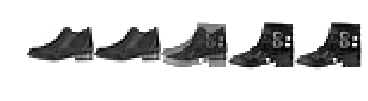

In [22]:
interps = []
for theta in thetas:
    
    logit_rho = torch.nn.Parameter(torch.Tensor(0*np.random.rand(1, 28*28)))
    optimizer = torch.optim.Adam([logit_rho], lr=0.03)
    
    for i in range(1000):

        optimizer.zero_grad()
       
        rho = torch.softmax(logit_rho, dim=1).view(1, 28, 28)
        
#         loss1 = renyi.renyi_sim_divergence(img_kernel, p, rho, alpha, use_avg=False)
#         loss2 = renyi.renyi_sim_divergence(img_kernel, q, rho, alpha, use_avg=False)
            
        loss1 = renyi.mink_sim_divergence(img_kernel, p, rho, alpha, use_inv=False, use_avg=True)
        loss2 = renyi.mink_sim_divergence(img_kernel, q, rho, alpha, use_inv=False, use_avg=True)
    
        loss = (1-theta) * loss1 + theta * loss2

        if i % 200 == 0:
            print("%.3f - %d - %.4e" % (theta, i, loss.item()))

        loss.backward()
        optimizer.step()
    
    interps.append(torch.softmax(logit_rho, dim=1))

    
plt.figure(figsize=(2*len(interps), 3))
W = torch.cat([p.view(28, 28) / p.max()] + [_.view(28, 28) / _.max() for _ in interps] + [q.view(28, 28) / q.max()], dim=1).data
#W = torch.cat([p.view(28, 28)] + [_.view(28, 28) for _ in interps] + [q.view(28, 28)], dim=1).data
plt.imshow(W, cmap='gray_r')
plt.axis('off');